In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer # 수치형, 결측치 채워줌
from sklearn.preprocessing import OneHotEncoder # 범주형

# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

1. csv 헤더는 뛰어쓰기xx

2. db select table 복사

    SELECT * INTO [new_table_name] FROM [original_table_name];

3. df.to_csv('temp.csv', index=False) #❗index= False

In [85]:
df = pd.read_csv('data/adult.csv', index_col=False)

data = df[['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income']] # ❗판다스 원하는 col 선택: [[]] 대괄호 2개
(age, workclass, education, gender, hours-per-week, occupation, income)

> data = { } # 딕셔너리
>
> data = [ ] # 리스트 # ❗배열과의 공통점: 인덱스는 정수

- loc vs. iloc
    - loc를 많이 씀.(iloc는 순서가 바뀔 수 있어서)

# Q. Income을 예측하는 간단한 모델을 작성해보세요.

- 이진분류 문제
    - 답안이 income(2개로 구성)

In [86]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [87]:
df[['income']].value_counts()
# 결과 분석: 1. 비율 안맞음 2. 이진분류 문제임

income
<=50K     24720
>50K       7841
Name: count, dtype: int64

In [88]:
# 결측치 확인 > 없음

## Q1. X,y(학습데이터와 정답지를 나눔)

In [89]:
X = df.drop('income', axis=1)
y = df['income'].apply(lambda x: 1 if x.strip() == '<=50K' else 0) # income이란 col에, apply 전체 적용, lambda 이름없는 함수에

## Q2 데이터를 split하세요

> #### 판다스 : 정형데이터를 다루는 도구(SQL, Excel과 유사)
>   - SQL은 반복문과 제어문이 없어서 사용불편
>   - SQL은 무결한 데이터에 특화
>   - Excel은 언어가 아님

[판다스 사용이유]
1. 데이터 불러오기 / 내보내기
2. 수학함수(f(X) <= numpy, scipy)
3. 제어문: if, 필터링(==)
    반복문: for(loc, iloc) -=> apply(f(x))  #f(x): 보통 람다식 사용. 무조건 반환하니까

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

## Q3. 수치형 데이터와 범주형 데이터를 분류

In [91]:
numeric_feat = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_feat = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

판다스쓸 수 없을때 sklearn으로 하는법 -> 정교함이 떨어짐

In [92]:
# 수치형
numeric_transformer = SimpleImputer(strategy='median') # 수치형 기준으로 null값이 사라짐, 이상치 정리됨
X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_feat])
X_test_numeric = numeric_transformer.transform(X_test[numeric_feat])

In [93]:
# 수치형
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

In [94]:
# 범주형
from sklearn.impute import SimpleImputer
categorical_transformer = SimpleImputer(strategy='constant', fill_value='missing') # 든게 뭔지 모르겠지만 일단 결과보기
X_train_categorical = categorical_transformer.fit_transform(X_train[categorical_feat])
X_test_categorical = categorical_transformer.transform(X_test[categorical_feat])

In [95]:
# 범주형
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_feat])
X_test_encoded = encoder.transform(X_test[categorical_feat])

#####  ```데이터``` --> ```모델``` --보고서-> ```배포``` ||| <-JSON-- ```웹(사용자)```
- 보고서에 없는 선택지는 JSON에서 받으면 안됨
- 일단 무시하고 잘못된 데이터를 log에 남겨둠 -> handle_unknown='ignore'

In [96]:
X_train_processed = np.hstack((X_train_scaled, X_train_encoded.toarray()))
X_test_processed = np.hstack((X_test_scaled, X_test_encoded.toarray()))

## Q4. 

> ❗RandomForest말고 DecisionTree로 해보기
    - 속도가 더 빠름

In [97]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

In [98]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test_processed)
accuracy_score(y_test, y_pred)

0.8534578061663186

65%정도는 뭐가 있구나하고

80%는 되야써볼까하고 

94%정도 될때 상용화

- Ensemble, Decision Tree의 차이
    - 트리는 고정인데, 앙상블은 바뀜 (주요특성 5개정도 먼저 보기)

- 'One-HotEncoding'을 쓸수록 numpy에 가까워짐

- 'GreedSearch'는 다 뒤져봐서 시간 오래걸림, 'Random_Greed_Search'로 해보고 하기

## Q5. 주요특성확인

In [99]:
feat_names = (numeric_feat + encoder.get_feature_names_out(categorical_feat).tolist())
feat_imp = model.feature_importances_
sorted_idx = np.argsort(feat_imp)[::-1]
for i in sorted_idx[:10]:
    if i < len(feat_names):
        print(f'{feat_names[i]}: {feat_imp[i]}')

fnlwgt: 0.1583855672863503
age: 0.14838175231560938
capital-gain: 0.09176459500772788
hours-per-week: 0.08444644623424477
marital-status_ Married-civ-spouse: 0.06481189756185203
education-num: 0.06440514877209341
relationship_ Husband: 0.03792819490485252
capital-loss: 0.029696464384324495
marital-status_ Never-married: 0.026095844872013937
occupation_ Exec-managerial: 0.01988036084250276


## 다항식

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
X, y = mglearn.datasets.make_wave(n_samples=128)
line = np.linspace(-3, 3, 1000, endpoint=True).reshape(-1, 1)
# np.arange()와 np.linspace() 둘 중 반환값이 동일하면 np.linespace() 사용하세요.
# numpy 매뉴얼에서 linspace 권장

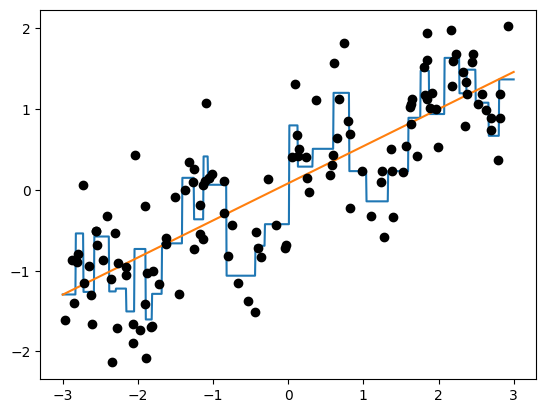

In [18]:
reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label='결정트리')
reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label='선형회귀')
plt.plot(X[:, 0], y, 'o', c='k')

In [34]:
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)

KBinsDiscretizer(encode='onehot-dense', n_bins=10, strategy='uniform')

In [35]:
X_binned = kb.transform(X)
line_binned = kb.transform(line)

In [39]:
X_combined = np.hstack([X, X_binned])
line_combined = np.hstack([line, line_binned])
# X_product = np.hstack([X * X * X_binned.reshape(1, -1)]) # X를 계속 곱해서 차수를 늘려가며 확인

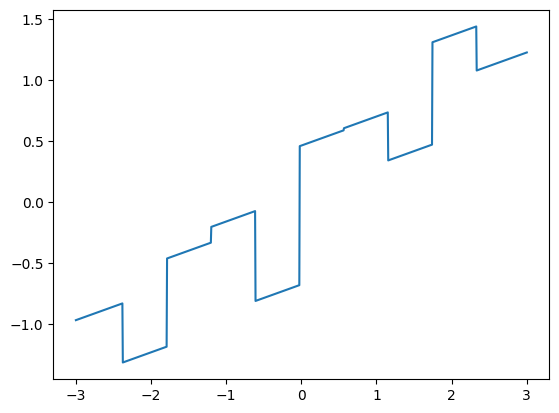

In [40]:
reg = LinearRegression().fit(X_combined, y)
plt.plot(line, reg.predict(line_combined), label='선형회귀')

In [41]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=10, include_bias=False) # 10차까지 튀김
poly.fit(X)
X_poly = poly.transform(X)

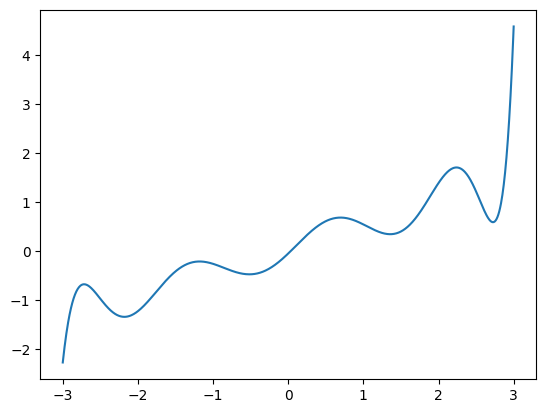

In [42]:
reg = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='선형회귀')

In [58]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif, SelectFromModel
from sklearn.model_selection import train_test_split

In [44]:
cancer = load_breast_cancer()

In [ ]:
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50)) # (568, 50)
X_w_noise = np.hstack([cancer.data, noise]) # (569, 80)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=42, test_size=0.5)

In [ ]:
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train) # (284, 40)

([<matplotlib.axis.YTick at 0x25acd163d60>], [Text(0, 0, '0')])

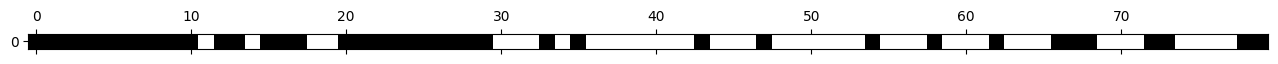

In [55]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap= 'gray_r')
plt.yticks([0])

In [57]:
from sklearn.linear_model import LogisticRegression
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
lr.fit(X_train_selected, y_train)
print(lr.score(X_test_selected, y_test))

0.9614035087719298
0.9649122807017544


In [ ]:
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), # 중요도 측정
    threshold='median'
)


In [64]:
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

([<matplotlib.axis.YTick at 0x25ad0902e20>], [Text(0, 0, '0')])

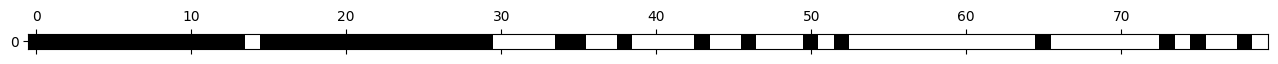

In [61]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap= 'gray_r')
plt.yticks([0])

In [65]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
lr.fit(X_train_selected, y_train)
print(lr.score(X_test_selected, y_test))

0.9614035087719298
0.9543859649122807
